# **Автор: Бабаева Нурай**

ПРИМЕЧАНИЕ. Для работы кода необходимо в среду загрузить архив Data_Science.zip, который был представлен в качестве задания.

In [1]:
# Необходимые импорты

# для обработки данных
from datetime import date
import numpy as np
import pandas as pd
import regex as re
import zipfile

# для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# для построения моделей
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# метрики
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# **1. Предварительная обработка данных**
---
**Раздел включает в себя:**
* обзор данных;
* определение типов признаков;
* удаление заведомо незначимых переменных;
* обработку пропусков и ошибок.

Предварительная обработка данных происходит по каждой таблице отдельно.

**Цель:** проверить качество и достоверность исходных данных, найти ошибки и пропуски, иными словами, подготовить таблицы к анализу и поиску закономерностей, визуализации и выдвижению гипотез о решении поставленной задачи.

In [2]:
# Объект архива
zf = zipfile.ZipFile('Data_Science.zip')


def open_df(df_file_name: str) -> pd.core.frame.DataFrame:
    """
    Возвращает DataFrame файла с расширением .parquet из архива Data_Science
    по названию df_file_name.
    """
    assert bool(re.fullmatch(r'\w+\.parquet', df_file_name)), "Неверный файл"
    return pd.read_parquet(zf.open(f'ГПН КАП/{df_file_name}'), engine='pyarrow')

In [3]:
# Сохраним все датасеты в переменные для удобства работы

transaction_df = open_df('transaction_df.parquet')
competitors_df = open_df('df_competitors.parquet')
weather_df = open_df('weather_df.parquet')
cost_df = open_df('df_cost.parquet')

In [4]:
# Дополнительные функции

def unique_values(df: pd.core.frame.DataFrame, left_indent: int, right_indent: int) -> None:
    """Выводит число уникальных значений в каждом признаке в df."""
    column_names = df.columns

    for i in range(len(column_names)):
        column_name = str(column_names[i]).ljust(left_indent)
        print(f"Число уникальных значений в признаке {column_name} -", end=" ")
        print(f"{str(df[column_names[i]].nunique()).rjust(right_indent)}")


def cat_unique_values(df: pd.core.frame.DataFrame, data_types: list[str]) -> None:
    """Выводит уникальные значения для каждого категориального признака в df."""
    column_names = df.select_dtypes(include=data_types).columns

    for column_name in column_names:
        print(f"Уникальные значения в признаке {column_name}:", end=" ")
        print(df[column_name].unique())


def positive_unique_values(column: pd.core.series.Series) -> list[float]:
    """Возвращает неотрицательные уникальные значения признака column."""
    round_2 = lambda num: round(num, 2)
    return list(map(round_2, filter(lambda x: x >= 0, column.unique())))


def negative_unique_values(column: pd.core.series.Series) -> list[float]:
    """Возвращает отрицательные уникальные значения признака column."""
    round_2 = lambda num: round(num, 2)
    return list(map(round_2, filter(lambda x: x < 0, column.unique())))

## **1.1. Данные о транзакциях**

### Обзор данных и анализ переменных

In [5]:
# информация о полях
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 875036 entries, 0 to 875035
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   product   875036 non-null  object        
 1   price     875036 non-null  float64       
 2   amount    875036 non-null  float64       
 3   place     874604 non-null  object        
 4   datetime  875036 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 33.4+ MB


In [6]:
# размерность данных, чтобы не потерять случайно строки или столбы в будущем
transaction_df.shape

(875036, 5)

In [7]:
# число пропущенных значений в поле place
transaction_df.shape[0] - transaction_df.place.notnull().sum()

432

In [9]:
# первые 10 строк
transaction_df.head(10)

,product,price,amount,place,datetime
0,Целебные травы,3.90,1.242125,Анор Лондо,2216-01-02 16:28:00
1,Целебные травы,3.90,-0.079689,Анор Лондо,2216-01-02 16:21:00
2,Целебные травы,3.90,0.882450,Анор Лондо,2216-01-02 03:03:00
3,Целебные травы,3.90,0.621377,Анор Лондо,2216-01-02 03:12:00
4,Целебные травы,3.90,1.367161,Анор Лондо,2216-01-02 05:33:00
5,Целебные травы,-7154.53,1.988265,Анор Лондо,2216-01-02 13:57:00
6,Целебные травы,3.90,1.736619,Анор Лондо,2216-01-02 11:54:00
7,Целебные травы,3.90,1.208150,Анор Лондо,2216-01-02 06:53:00
8,Целебные травы,3.90,1.826042,Анор Лондо,2216-01-02 12:05:00
9,Целебные травы,3.90,1.983822,Анор Лондо,2216-01-02 01:55:00


In [10]:
# последние 10 строк
transaction_df.tail(10)

,product,price,amount,place,datetime
875026,Эстус,9.28,1.444754,Фалькония,2218-09-27 12:13:00
875027,Эстус,9.28,-0.006291,Фалькония,2218-09-27 23:25:00
875028,Эстус,9.28,0.713978,Фалькония,2218-09-27 20:03:00
875029,Эстус,9.28,-0.187556,Фалькония,2218-09-27 23:02:00
875030,Эстус,9.28,-0.026184,Фалькония,2218-09-27 23:32:00
875031,Эстус,9.28,1.079104,Фалькония,2218-09-27 14:50:00
875032,Эстус,9.28,1.580617,Фалькония,2218-09-27 06:16:00
875033,Эстус,9.28,1.738492,Фалькония,2218-09-27 11:14:00
875034,Эстус,9.28,0.430340,Фалькония,2218-09-27 22:24:00
875035,Эстус,9.28,0.090248,Фалькония,2218-09-27 17:50:00


In [11]:
# посмотрим на число уникальных значений в каждом признаке

unique_values(transaction_df, 8, 6)
print()
cat_unique_values(transaction_df, data_types=['object'])

Число уникальных значений в признаке product  -      3
Число уникальных значений в признаке price    -  53926
Число уникальных значений в признаке amount   - 875036
Число уникальных значений в признаке place    -      5
Число уникальных значений в признаке datetime - 652717

Уникальные значения в признаке product: ['Целебные травы' 'Эльфийская пыльца' 'Эстус']
Уникальные значения в признаке place: ['Анор Лондо' None 'Врата Балдура' 'Кеджистан' 'Нокрон' 'Фалькония']


In [12]:
# посмотрим на характеристики количественных переменных
transaction_df.describe()

,price,amount
count,875036.000000,875036.000000
mean,-299.886482,0.739259
std,1407.438729,0.717872
min,-9998.990000,-0.500000
25%,6.850000,0.119508
50%,9.730000,0.733257
75%,13.800000,1.356674
max,31.200000,1.999999


**Выводы по обзору данных:**

1. Датасет содержит $875\ 036$ строк и $5$ столбцов.

2. Датасет содержит две количественные переменные: `price`, `amount`, и три категориальные переменные: `product`, `place`, `datetime`. При этом `datetime` — объект типа `timestamp`, поэтому обозначать это поле как строго категориальную не будем.

3. Имена полей соответствуют стилю `snake_case`, поэтому не будем их переименовывать.

4. Поле `place` содержит пропуски ($432$), их необходимо обработать.

5. При обзоре строк с начала и конца датасета были обнаружены ошибки в данных: поля `price` и `amount` содержат отрицательные значения, что противоречит их физическому смыслу. Данные ошибки также необходимо обработать.

6. При обзоре уникальных значений можно сказать, что:
    * признак `product` не имеет ошибок и пропусков;
    * признак `price` имеет примерно $54\ 000$ уникальных значений (хотя наблюдений примерно в $16$ раз больше), эта информация поможет принять решение при обработке ошибок без потери существенных данных;
    * признак `amount` не имеет пропусков, но имеет ошибки, их достаточно много, поэтому обработать необходимо после детального анализа;
    * признак `place` содержит значения `None`, необходимо обработать;
    * признак `datetime` пока не играет существенной роли, детально его рассмотрим в следующем разделе.


### Устранение ошибок

Исправим ошибки в поле `price`:



In [13]:
# посмотрим на то, как менялась цена в зависимости от места и товара
transaction_df.groupby(['place', 'product']).aggregate({'price': [positive_unique_values, negative_unique_values]})

price  \
                                                            positive_unique_values   
place         product                                                                
Анор Лондо    Целебные травы     [3.9, 4.3, 4.6, 5.07, 5.57, 5.52, 5.92, 6.51, ...   
              Эльфийская пыльца  [9.21, 9.8, 9.9, 10.39, 10.31, 10.28, 10.86, 1...   
              Эстус              [3.6, 4.0, 3.86, 3.89, 4.01, 4.21, 4.03, 4.36,...   
Врата Балдура Целебные травы     [7.29, 7.59, 7.57, 8.04, 7.91, 7.95, 8.03, 8.5...   
              Эльфийская пыльца  [13.42, 13.77, 13.82, 13.72, 14.01, 14.19, 14....   
              Эстус              [7.8, 7.87, 7.72, 7.64, 8.1, 8.42, 8.43, 8.4, ...   
Кеджистан     Целебные травы     [3.69, 3.89, 4.28, 4.2, 4.49, 4.87, 5.22, 5.71...   
              Эльфийская пыльца  [9.05, 9.34, 9.6, 9.62, 9.52, 9.61, 10.08, 10....   
              Эстус              [4.19, 4.7, 4.84, 5.31, 5.49, 6.04, 6.46, 6.43...   
Нокрон        Целебные травы     [2.73, 3.0, 3.27, 3.37, 3.28, 3.42, 3.71, 3.75...   
              Эльфийская пыльца  [8.65, 8.92, 9.04, 9.09, 9.17, 9.33, 9.27, 9.4...   
              Эстус              [2.87, 3.05, 3.3, 3.22, 3.4, 3.45, 3.62, 3.66,...   
Фалькония     Целебные травы     [6.39, 6.71, 6.6, 6.65, 6.38, 6.3, 6.42, 6.55,...   
              Эльфийская пыльца  [11.32, 11.52, 11.48, 11.65, 11.74, 11.71, 11....   
              Эстус              [6.27, 6.76, 6.69, 7.04, 6.97, 6.84, 6.85, 6.6...   

                                                                                    
                                                            negative_unique_values  
place         product                                                               
Анор Лондо    Целебные травы     [-7154.53, -8870.9, -7675.59, -5165.77, -1481....  
              Эльфийская пыльца  [-1263.59, -1602.39, -8947.87, -5517.56, -2923...  
              Эстус              [-3351.75, -1392.72, -6401.78, -8651.04, -5067...  
Врата Балдура Целебные травы     [-4069.9, -762.84, -3183.57, -6569.22, -3062.4...  
              Эльфийская пыльца  [-5569.01, -630.46, -8458.01, -2635.89, -6634....  
              Эстус              [-453.12, -2379.13, -2629.47, -2090.27, -5820....  
Кеджистан     Целебные травы     [-1446.54, -97.57, -3317.83, -546.44, -1274.31...  
              Эльфийская пыльца  [-9427.87, -5068.36, -347.4, -8977.28, -9496.4...  
              Эстус              [-9778.19, -4884.03, -5905.43, -4298.58, -218....  
Нокрон        Целебные травы     [-6542.95, -8177.96, -2610.63, -5636.45, -393....  
              Эльфийская пыльца  [-1217.62, -6112.97, -5623.35, -1946.0, -7093....  
              Эстус              [-3546.59, -9051.57, -112.39, -8821.21, -893.7...  
Фалькония     Целебные травы     [-2377.67, -5039.65, -9896.53, -1287.68, -7903...  
              Эльфийская пыльца  [-2476.51, -3942.61, -3046.16, -4941.41, -5420...  
              Эстус              [-4644.29, -508.23, -3925.65, -229.31, -5721.9...

Интересно посмотреть динамику цены в разрезе: каждый продукт в каждом городе каждый день. Для этого составим `DataFrame`:

In [14]:
# для удобства анализа цены добавим новые поля
transaction_df['year'] = transaction_df['datetime'].dt.year
transaction_df['month'] = transaction_df['datetime'].dt.month
transaction_df['day'] = transaction_df['datetime'].dt.day

transaction_price_data = transaction_df.groupby(['product', 'place', 'year', 'month']) \
    .aggregate({'price': [positive_unique_values, negative_unique_values]})

In [15]:
transaction_price_data.iloc[:12, :]

price  \
                                     positive_unique_values   
product        place      year month                          
Целебные травы Анор Лондо 2216 1                 [3.9, 4.3]   
                               2           [4.3, 4.6, 5.07]   
                               3               [5.07, 5.57]   
                               4         [5.57, 5.52, 5.92]   
                               5               [5.92, 6.51]   
                               6         [6.51, 6.34, 6.93]   
                               7               [6.93, 6.74]   
                               8               [6.74, 7.23]   
                               9          [7.23, 7.01, 7.5]   
                               10         [7.5, 7.32, 7.81]   
                               11              [7.81, 8.08]   
                               12              [8.08, 8.04]   

                                                                                         
                                                                 negative_unique_values  
product        place      year month                                                     
Целебные травы Анор Лондо 2216 1      [-7154.53, -8870.9, -7675.59, -5165.77, -1481....  
                               2      [-7009.29, -2163.17, -9529.34, -5841.09, -3444...  
                               3      [-5472.59, -4241.65, -8702.23, -9336.73, -9594...  
                               4      [-6473.83, -9160.57, -3685.63, -5381.38, -4348...  
                               5      [-5202.24, -6714.54, -2780.06, -3717.48, -2435...  
                               6      [-8094.75, -4232.95, -3567.88, -6546.13, -8579...  
                               7      [-4648.45, -8856.77, -5934.17, -216.27, -6546....  
                               8      [-5241.44, -3387.68, -8434.05, -9596.71, -3237...  
                               9      [-4477.06, -4849.36, -332.81, -6881.22, -7052....  
                               10     [-5910.13, -8596.52, -8760.1, -3538.93, -4994....  
                               11     [-5780.39, -6190.21, -5400.34, -6603.9, -9052....  
                               12     [-5105.47, -1554.07, -4661.24, -5573.99, -1703...

In [16]:
# размерность данных
transaction_price_data.shape

(495, 2)

<Axes: >

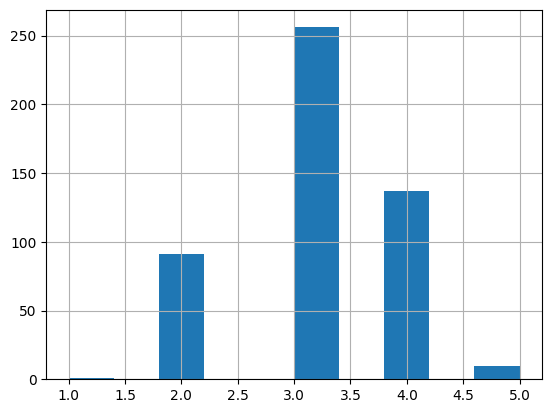

In [18]:
# проверим число уникальных значений в каждой строке
transaction_price_data[('price', 'positive_unique_values')].map(len).hist()

<Axes: >

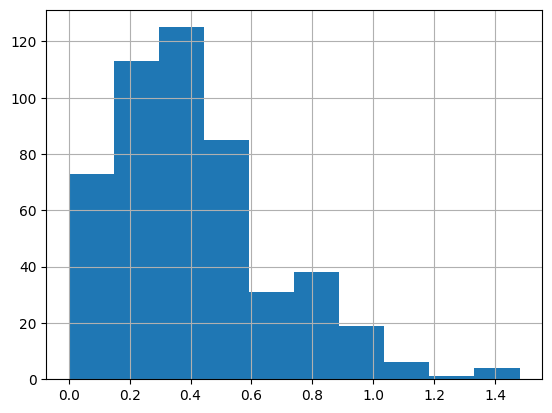

In [19]:
# проверим размах уникальных значений в каждой строке
transaction_price_data[('price', 'positive_unique_values')].map(lambda x: max(x) - min(x)).hist()

In [20]:
# посмотрим долю отрицательных значений
transaction_price_data[('price', 'negative_unique_values')].map(len).sum() / transaction_df.shape[0] * 100

6.203630479203142

Таким образом, на месяц в основном приходится три действительные цены (с точностью до сотых), это говорит о том, что можно проверить в каких диапазонах находятся ошибочные данные и заменить их на те цены, которые были в заданный период.

При этом надо учесть правило о трех днях, когда цена не должна меняться.

**Тогда будем руководствоваться следующим правилом:**
* если ошибочная цена находится во временном интервале, который характеризуется одной ценой до ошибочной и после ошибочной, то ошибочную цену можно заменить на постоянную;
* если ошибочная цена находится во временном интервале, который характеризуется одной постоянной ценой до ошибочной и другой постоянной ценой после ошибочной, то ошибочную цену можно удалить или заменить на среднее значение постоянных цен.

**Цель:** восстановить данные, не искажая их. Для начала реализуем первое правило.

In [21]:
# проверим датасет
print(transaction_df.shape)
transaction_df.head()

(875036, 8)


,product,price,amount,place,datetime,year,month,day
0,Целебные травы,3.9,1.242125,Анор Лондо,2216-01-02 16:28:00,2216,1,2
1,Целебные травы,3.9,-0.079689,Анор Лондо,2216-01-02 16:21:00,2216,1,2
2,Целебные травы,3.9,0.882450,Анор Лондо,2216-01-02 03:03:00,2216,1,2
3,Целебные травы,3.9,0.621377,Анор Лондо,2216-01-02 03:12:00,2216,1,2
4,Целебные травы,3.9,1.367161,Анор Лондо,2216-01-02 05:33:00,2216,1,2


> Если бы у меня было больше времени, я бы отдельно проверила удовлетворение динамики цены правилу "цена должна быть постоянной в течении $3$ дней" и "цена не может быть измнена на больше, чем $1$ золотых, за раз".

In [22]:
# заменяем отрицательные значения по условию
for i in range(1, len(transaction_df['price']) - 1):
    if transaction_df['price'][i] < 0:
        if transaction_df['price'][i - 1] == transaction_df['price'][i + 1]:
            transaction_df.at[i, 'price'] = transaction_df.at[i - 1, 'price']

In [23]:
# посмотрим на число оставшихся отрицательных значений
(transaction_df.price < 0).sum()

8020

In [24]:
# посмотрим на их долю
(transaction_df.price < 0).sum() / transaction_df.shape[0] * 100

0.9165337197555301

Так как доля оставшихся ошибок достаточно мала, мы их удалим.

In [25]:
# проверка размерности
transaction_df.shape[0]

875036

In [26]:
# удалим лишние данные
transaction_df = transaction_df.loc[transaction_df['price'] >= 0]
print(transaction_df.shape[0], transaction_df.shape[0] + 8_020)

867016 875036


In [27]:
# снова проверка на отрицательные (и нулевые) значения
print((transaction_df.price < 0).sum(), (transaction_df.price == 0).sum())

0 0


Исправим ошибки в поле `place`:

In [28]:
# действуем по аналогии
transaction_place_data = transaction_df.groupby(['year', 'month', 'day']) \
    .aggregate({'place': 'unique'})

transaction_place_data.iloc[:15, :]

place
year month day                                                   
2216 1     2    [Анор Лондо, Врата Балдура, Кеджистан, Нокрон,...
           3    [Анор Лондо, Врата Балдура, Кеджистан, Нокрон,...
           4    [Анор Лондо, Врата Балдура, Кеджистан, Нокрон,...
           5    [Анор Лондо, Врата Балдура, Кеджистан, None, Н...
           6    [Анор Лондо, Врата Балдура, Кеджистан, None, Н...
           7    [Анор Лондо, Врата Балдура, Кеджистан, Нокрон,...
           8    [Анор Лондо, Врата Балдура, Кеджистан, Нокрон,...
           9    [Анор Лондо, Врата Балдура, Кеджистан, Нокрон,...
           10   [Анор Лондо, None, Врата Балдура, Кеджистан, Н...
           11   [Анор Лондо, Врата Балдура, None, Кеджистан, Н...
           12   [Анор Лондо, Врата Балдура, Кеджистан, Нокрон,...
           13   [Анор Лондо, Врата Балдура, Кеджистан, Нокрон,...
           14   [Анор Лондо, Врата Балдура, Кеджистан, Нокрон,...
           15   [Анор Лондо, Врата Балдура, Кеджистан, Нокрон,...
           16   [Анор Лондо, Врата Балдура, Кеджистан, Нокрон,...

In [29]:
# посмотрим на их долю
transaction_df.place.isnull().sum() / transaction_df.shape[0] * 100

0.049364717606134145

Так как доля ошибок очень мала, мы их удалим.

In [30]:
transaction_df = transaction_df.dropna()

In [31]:
# проверка
transaction_df.place.isnull().sum()

0

In [32]:
# проверка размерности
print(transaction_df.shape[0], transaction_df.shape[0] + 428)

866588 867016


In [33]:
transaction_df.head()

,product,price,amount,place,datetime,year,month,day
0,Целебные травы,3.9,1.242125,Анор Лондо,2216-01-02 16:28:00,2216,1,2
1,Целебные травы,3.9,-0.079689,Анор Лондо,2216-01-02 16:21:00,2216,1,2
2,Целебные травы,3.9,0.882450,Анор Лондо,2216-01-02 03:03:00,2216,1,2
3,Целебные травы,3.9,0.621377,Анор Лондо,2216-01-02 03:12:00,2216,1,2
4,Целебные травы,3.9,1.367161,Анор Лондо,2216-01-02 05:33:00,2216,1,2


In [34]:
# обновим индексы
transaction_df.reset_index(drop=True, inplace=True)

In [35]:
transaction_df.head()

,product,price,amount,place,datetime,year,month,day
0,Целебные травы,3.9,1.242125,Анор Лондо,2216-01-02 16:28:00,2216,1,2
1,Целебные травы,3.9,-0.079689,Анор Лондо,2216-01-02 16:21:00,2216,1,2
2,Целебные травы,3.9,0.882450,Анор Лондо,2216-01-02 03:03:00,2216,1,2
3,Целебные травы,3.9,0.621377,Анор Лондо,2216-01-02 03:12:00,2216,1,2
4,Целебные травы,3.9,1.367161,Анор Лондо,2216-01-02 05:33:00,2216,1,2


Исправим ошибки в поле `amount`:

0.7392600498593127


<Axes: >

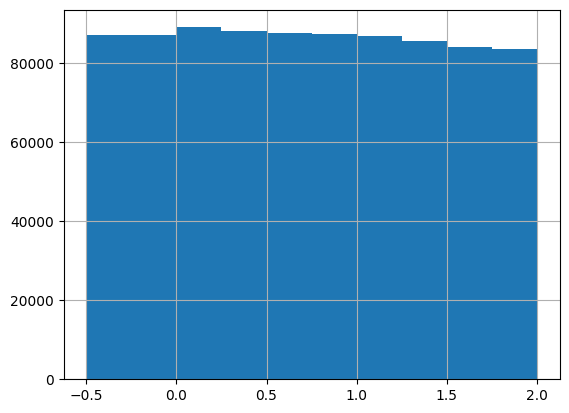

In [36]:
# визуализируем значения
print(transaction_df.amount.mean())
transaction_df.amount.hist()

Здесь ошибки не критичные, то есть если взять каждое значение по модулю, то значения будут до $0.5$. Однако такой подход может исказить данные. Также если мы заменим на среднее значение, то тоже сместим данные. Попробуем заменить отрицательные значения на случайно число из диапазона значений количества продукта.

In [37]:
transaction_df.groupby(['product', 'place']).aggregate({'amount': 'mean'})

amount
product           place                  
Целебные травы    Анор Лондо     0.737431
                  Врата Балдура  0.734577
                  Кеджистан      0.739500
                  Нокрон         0.742140
                  Фалькония      0.744644
Эльфийская пыльца Анор Лондо     0.739717
                  Врата Балдура  0.737667
                  Кеджистан      0.738556
                  Нокрон         0.737569
                  Фалькония      0.738750
Эстус             Анор Лондо     0.734532
                  Врата Балдура  0.736152
                  Кеджистан      0.742371
                  Нокрон         0.743358
                  Фалькония      0.739072

In [38]:
# нулевые значения
(transaction_df.amount == 0).sum()

0

In [39]:
min_amount = transaction_df[transaction_df.amount.unique() > 0].amount.min()
max_amount = transaction_df[transaction_df.amount.unique() > 0].amount.max()

In [40]:
# заменим на случайное значение для каждой подгруппы товаров и городов
for i in range(len(transaction_df['amount'])):
    if transaction_df['amount'][i] < 0:
        transaction_df.at[i, 'amount'] = np.random.uniform(min_amount, max_amount)

0.9900529842867366


<Axes: >

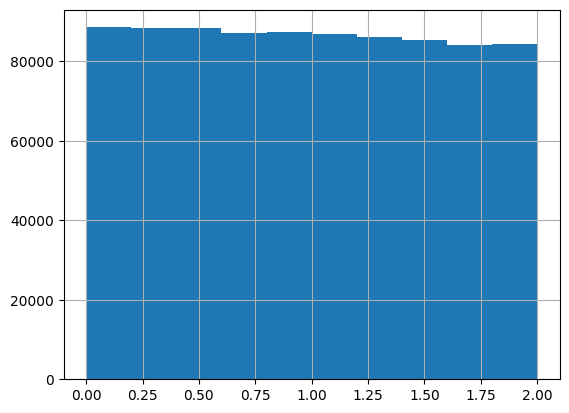

In [41]:
# проверка
# визуализируем значения
print(transaction_df.amount.mean())
transaction_df.amount.hist()

In [42]:
# дополнительная проверка
# нулевые и отрицательные значения
print((transaction_df.amount == 0).sum(), (transaction_df.amount < 0).sum())
print(transaction_df.shape)

0 0
(866588, 8)


In [43]:
transaction_df.head()

,product,price,amount,place,datetime,year,month,day
0,Целебные травы,3.9,1.242125,Анор Лондо,2216-01-02 16:28:00,2216,1,2
1,Целебные травы,3.9,0.584359,Анор Лондо,2216-01-02 16:21:00,2216,1,2
2,Целебные травы,3.9,0.882450,Анор Лондо,2216-01-02 03:03:00,2216,1,2
3,Целебные травы,3.9,0.621377,Анор Лондо,2216-01-02 03:12:00,2216,1,2
4,Целебные травы,3.9,1.367161,Анор Лондо,2216-01-02 05:33:00,2216,1,2


**Выводы по очистке данных:**

1. Размерность данных составляет $866\ 588$ строк и $8$ столбцов.
2. Данные содержат количественные и категориальные переменные. Решение о представлении категориальных переменных будет принято в следующем разделе.
3. Устранены ошибки в данных по полям `price`, `place` и `amount`.


> Если бы у меня было бы больше времени, я бы отдельно исследовала пункт об устранении ошибок в поле `amount`. Мне кажется, замена на случайное число из диапазона может исказить характер данных. Но здесь была цель не изменить исходное распределение данных.

## **1.2. Данные о ценах конкурентов**

### Обзор данных и анализ переменных

In [44]:
# информация о полях
competitors_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31799 entries, 0 to 39456
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   place       31799 non-null  object        
 1   product     31799 non-null  object        
 2   competitor  31799 non-null  object        
 3   price       31799 non-null  float64       
 4   date        31799 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 1.5+ MB


In [45]:
# размерность данных, чтобы не потерять случайно строки или столбы в будущем
competitors_df.shape

(31799, 5)

In [46]:
# число пропусков
39_456 - competitors_df.shape[0] + 1

7658

In [47]:
# первые 10 строк
competitors_df.head(10)

,place,product,competitor,price,date
0,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-04
1,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-05
2,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-06
3,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-09
5,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-11
6,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-12
7,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-13
9,Анор Лондо,Целебные травы,Арториас&Co,4.03,2216-01-17
10,Анор Лондо,Целебные травы,Арториас&Co,4.03,2216-01-18
12,Анор Лондо,Целебные травы,Арториас&Co,4.03,2216-01-21


In [48]:
# последние 10 строк
competitors_df.tail(10)

,place,product,competitor,price,date
39445,Фалькония,Эстус,Светлые Души,14.99,2218-09-06
39446,Фалькония,Эстус,Светлые Души,14.99,2218-09-10
39447,Фалькония,Эстус,Светлые Души,14.99,2218-09-11
39448,Фалькония,Эстус,Светлые Души,14.99,2218-09-12
39450,Фалькония,Эстус,Светлые Души,14.99,2218-09-14
39451,Фалькония,Эстус,Светлые Души,14.99,2218-09-17
39453,Фалькония,Эстус,Светлые Души,15.36,2218-09-20
39454,Фалькония,Эстус,Светлые Души,15.36,2218-09-22
39455,Фалькония,Эстус,Светлые Души,15.36,2218-09-23
39456,Фалькония,Эстус,Светлые Души,15.36,2218-09-24


In [49]:
# посмотрим на число уникальных значений в каждом признаке

unique_values(competitors_df, 10, 5)
print()
cat_unique_values(competitors_df, data_types=['object'])

Число уникальных значений в признаке place      -     5
Число уникальных значений в признаке product    -     3
Число уникальных значений в признаке competitor -     4
Число уникальных значений в признаке price      -  3508
Число уникальных значений в признаке date       -  1000

Уникальные значения в признаке place: ['Анор Лондо' 'Врата Балдура' 'Кеджистан' 'Нокрон' 'Фалькония']
Уникальные значения в признаке product: ['Целебные травы' 'Эльфийская пыльца' 'Эстус']
Уникальные значения в признаке competitor: ['Арториас&Co' 'Длань господня' 'ЛилIT' 'Светлые Души']


In [50]:
# посмотрим на характеристики количественных переменных
competitors_df.describe()

,price
count,31799.000000
mean,11.894810
std,5.574935
min,2.850000
25%,7.780000
50%,11.050000
75%,15.030000
max,31.940000


**Выводы по обзору данных:**

1. Датасет содержит $31\ 799$ строк и $5$ столбцов.

2. Датасет содержит одну количественную переменную: `price`, и четыре категориальные переменные: `product`, `place`, `competitor`, `date`. При этом `date` — объект типа `timestamp`, поэтому обозначать это поле как строго категориальную не будем.

3. Имена полей соответствуют стилю `snake_case`, поэтому не будем их переименовывать.

4. При обзоре строк с начала и конца датасета были обнаружены пропуски наблюдений: максимальное значение индекса составляет $39\ 457$, а фактических наблюдений всего $31\ 799$. Необходимо восстановить $7\ 658$ строк.

5. При обзоре уникальных значений можно сказать, что:
    * признак `place` не имеет ошибок и пропусков;
    * признак `product` не имеет ошибок и пропусков;
    * признак `competitor` не имеет ошибок и пропусков;
    * признак `price` имеет примерно $3\ 508$ уникальных значений (хотя наблюдений примерно в $9$ раз больше), эта информация поможет принять решение при обработке пропусков без потери исходного смысла данных;
    * признак `date` имеет примерно $1\ 000$ уникальных значений (хотя наблюдений примерно в $31$ раз больше), эта информация поможет принять решение при обработке пропусков без потери исходного смысла данных.


### Устранение пропусков

In [51]:
# для удобства анализа цены добавим новые поля
# competitors_df['year'] = competitors_df['datetime'].dt.year
# competitors_df['month'] = competitors_df['datetime'].dt.month
# competitors_df['day'] = competitors_df['datetime'].dt.day

competitors_df.groupby(['product']).aggregate({'date': 'nunique'})

,date
product,
Целебные травы,1000
Эльфийская пыльца,1000
Эстус,1000


In [52]:
competitors_df.head(10)

,place,product,competitor,price,date
0,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-04
1,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-05
2,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-06
3,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-09
5,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-11
6,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-12
7,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-13
9,Анор Лондо,Целебные травы,Арториас&Co,4.03,2216-01-17
10,Анор Лондо,Целебные травы,Арториас&Co,4.03,2216-01-18
12,Анор Лондо,Целебные травы,Арториас&Co,4.03,2216-01-21


In [53]:
# создадим новый датафрейм, в котором будут все пропуски

all_indices = range(39_456)
current_indices = list(filter(lambda x: x in competitors_df.index, all_indices))
null_indices = list(filter(lambda x: x not in competitors_df.index, all_indices))

# первые 10 недостающих индексов
null_indices[:10]

[4, 8, 11, 17, 19, 22, 23, 24, 25, 31]

**Будем руководствоваться следующим правилом:**
* если строка пропуска находится между двумя идентичными наблюдениями (по полям `price`, `product`, `competitor`), то строка пропуска может быть восстановлена значеними из этих наблюдений;
* если строка пропуска находится между двумя различными наблюдениями, то необходимо провести дополнительное исследование на поиск возможных замен;
* если строка пропуска находится с одной или двух сторон с пропусками, то логично заменить на ближайшую предыдущую строку.  

**Правило восстановления даты:**
* если строка пропуска находится между двумя идентичными наблюдениями (по полям `place`, `product`, `competitor`), то:
    * если поля `date` также идентичны, то дата пропуска равна им;
    * если поля `date` различны и их разница составляет 1 день (например, 2216-01-09 и 2216-01-10), то мы получаем строку дубликат, которую потом необходимо удалить, так как данные получаются неинформативными;
    * если поля `date` различны и их разница составляет более 1 дня, то дата пропуска может быть равна дате предыдущего наблюдения, увеличенного на 1 день.
* если строка пропуска находится между двумя различными наблюдениями, то необходимо провести дополнительное исследование на поиск возможных замен.

**Цель:** восстановить данные, не искажая их. Для начала реализуем первое правило.

In [69]:
null_data = {
    'place': [],
    'product': [],
    'competitor': [],
    'price': [],
    'date': []
}


def competitors_check(i: int, current_indices: list[int]) -> bool:
    """
    Возвращает True, если строки i - 1 и i + 1 идентичны по полям
    price, product, competitor, price.
    """
    # если предыдущая строка и последующая не являются пропусками и идентичны
    if ((i - 1) in current_indices) and ((i + 1) in current_indices):
        is_place = competitors_df['place'][i - 1] == competitors_df['place'][i + 1]
        is_product = competitors_df['product'][i - 1] == competitors_df['product'][i + 1]
        is_comp = competitors_df['competitor'][i - 1] == competitors_df['competitor'][i + 1]
        # is_price =  competitors_df['price'][i - 1] == competitors_df['price'][i + 1]
        data_cond = (competitors_df['date'][i + 1].day - competitors_df['date'][i - 1].day) in (0, 1)
        flag = (is_place, is_product, is_comp)
    # если только предыдущая строка не является пропуском
    elif (i - 1) in current_indices:
        data_cond = False
        flag = (True, )
    else:
        flag = (False, )

    if all(flag):
        data = {
                'place': competitors_df['place'][i - 1],
                'product': competitors_df['product'][i - 1],
                'competitor': competitors_df['competitor'][i - 1],
                'price': competitors_df['price'][i - 1],
                'date': competitors_df['date'][i - 1] if data_cond else competitors_df['date'][i - 1] + pd.DateOffset(days=1)
            }
    else:
        data = {}

    return all(flag), data


# заполним словарь новыми данными по первому правилу
for i in null_indices:
    condition, data = competitors_check(i, current_indices)
    if condition:
       null_data['place'].append(data['place'])
       null_data['product'].append(data['product'])
       null_data['competitor'].append(data['competitor'])
       null_data['price'].append(data['price'])
       null_data['date'].append(data['date'])
    else:
       null_data['place'].append(None)
       null_data['product'].append(None)
       null_data['competitor'].append(None)
       null_data['price'].append(None)
       null_data['date'].append(None)


null_df = pd.DataFrame(null_data, index=null_indices)
null_df.head()

,place,product,competitor,price,date
4,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-10
8,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-14
11,Анор Лондо,Целебные травы,Арториас&Co,4.03,2216-01-19
17,Анор Лондо,Целебные травы,Арториас&Co,4.03,2216-01-28
19,Анор Лондо,Целебные травы,Арториас&Co,4.03,2216-01-31


In [70]:
# не хватает тех данных, которые находятся между пропусками
null_df[['price', 'date']].iloc[:10, :]

,price,date
4,3.78,2216-01-10
8,3.78,2216-01-14
11,4.03,2216-01-19
17,4.03,2216-01-28
19,4.03,2216-01-31
22,4.03,2216-02-03
23,NaN,NaT
24,NaN,NaT
25,NaN,NaT
31,3.99,2216-02-23


In [71]:
competitors_df.iloc[16:20, :]

,place,product,competitor,price,date
21,Анор Лондо,Целебные травы,Арториас&Co,4.03,2216-02-02
26,Анор Лондо,Целебные травы,Арториас&Co,3.99,2216-02-15
27,Анор Лондо,Целебные травы,Арториас&Co,3.99,2216-02-18
28,Анор Лондо,Целебные травы,Арториас&Co,3.99,2216-02-19


In [72]:
# проверка соответствия размеров пропусков
null_df.place.notna().sum() + null_df.place.isna().sum()

7658

In [73]:
# доля восстановленных данных
null_df.notna().sum() / len(null_indices) * 100

place         80.425699
product       80.425699
competitor    80.425699
price         80.425699
date          80.425699
dtype: float64

In [74]:
# доля восстановленных данных к общему числу данных
(competitors_df.shape[0] + null_df.notna().sum()) / len(all_indices) * 100

place         96.203366
product       96.203366
competitor    96.203366
price         96.203366
date          96.203366
dtype: float64

Их можно заполнить цепочкой, увеличивая дату на $1$ день (если это возможно), так как всегда есть ближайшие непустые строки.

> Если бы у меня было больше времени, я бы проанализировала тут еще динамику цены, чтобы иначе заполнить пропуски, которые находятся между пропусками. Пока портить данные не хочу. К тому же удалось большую часть утерянных данных восстановить (примерно $80.43\%$), и доля восстановленных данных к общему числу составляет примерно $96.20\%$.

Теперь объединим датафреймы и удалим дубликаты и пустые строки. Посмотрим полученную размерность данных.

In [75]:
new_competitors_df = competitors_df.append(null_df)

<ipython-input-75-56bcf9d53919>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_competitors_df = competitors_df.append(null_df)


In [76]:
new_competitors_df.reset_index(drop=True, inplace=True)

In [77]:
new_competitors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39457 entries, 0 to 39456
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   place       37958 non-null  object        
 1   product     37958 non-null  object        
 2   competitor  37958 non-null  object        
 3   price       37958 non-null  float64       
 4   date        37958 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 1.5+ MB


In [78]:
new_competitors_df.dropna(inplace=True)

In [80]:
# проверка
new_competitors_df.isna().sum()

place         0
product       0
competitor    0
price         0
date          0
dtype: int64

In [81]:
new_competitors_df.drop_duplicates(inplace=True)

In [82]:
# проверка размерности
print(new_competitors_df.shape, new_competitors_df.shape[0] + 1499)

(37958, 5) 39457


In [83]:
new_competitors_df.head(25)

,place,product,competitor,price,date
0,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-04
1,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-05
2,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-06
3,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-09
4,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-11
5,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-12
6,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-13
7,Анор Лондо,Целебные травы,Арториас&Co,4.03,2216-01-17
8,Анор Лондо,Целебные травы,Арториас&Co,4.03,2216-01-18
9,Анор Лондо,Целебные травы,Арториас&Co,4.03,2216-01-21


**Вывод по восстановлению пропусков:**
1. Размерность данных составляет $37\ 958$ строк и $5$ столбцов.
2. Данные содержат количественные и категориальные переменные. Решение о представлении категориальных переменных будет принято в следующем разделе.
3. Восстановлены данные с учетом положения строки пропуска, те строки, в которых сложно было идентифицировать исходные данные, были удалены. Полученный датафрейм не содержит дубликатов и пропусков.

## **1.3. Данные о погоде**



### Обзор данных и анализ переменных

In [54]:
# информация о полях
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   place   5000 non-null   object        
 1   hot     5000 non-null   int64         
 2   rain    5000 non-null   int64         
 3   snow    5000 non-null   int64         
 4   date    5000 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 195.4+ KB


In [55]:
# размерность данных, чтобы не потерять случайно строки или столбы в будущем
weather_df.shape

(5000, 5)

In [57]:
# первые 10 строк
weather_df.head(10)

,place,hot,rain,snow,date
0,Фалькония,0,0,0,2216-01-02
1,Анор Лондо,1,0,0,2216-01-02
2,Врата Балдура,0,0,1,2216-01-02
3,Нокрон,0,0,0,2216-01-02
4,Кеджистан,0,0,1,2216-01-02
5,Фалькония,0,0,1,2216-01-03
6,Анор Лондо,1,0,0,2216-01-03
7,Врата Балдура,0,0,1,2216-01-03
8,Нокрон,0,0,1,2216-01-03
9,Кеджистан,0,0,0,2216-01-03


In [58]:
# последние 10 строк
weather_df.tail(10)

,place,hot,rain,snow,date
4990,Фалькония,0,0,1,2218-09-26
4991,Анор Лондо,0,0,0,2218-09-26
4992,Врата Балдура,0,0,1,2218-09-26
4993,Нокрон,0,0,0,2218-09-26
4994,Кеджистан,0,0,0,2218-09-26
4995,Фалькония,0,0,0,2218-09-27
4996,Анор Лондо,0,0,1,2218-09-27
4997,Врата Балдура,1,0,0,2218-09-27
4998,Нокрон,0,0,0,2218-09-27
4999,Кеджистан,0,0,0,2218-09-27


In [59]:
# посмотрим на число уникальных значений в каждом признаке

unique_values(weather_df, 8, 6)
print()
cat_unique_values(weather_df, data_types=['object'])

Число уникальных значений в признаке place    -      5
Число уникальных значений в признаке hot      -      2
Число уникальных значений в признаке rain     -      2
Число уникальных значений в признаке snow     -      2
Число уникальных значений в признаке date     -   1000

Уникальные значения в признаке place: ['Фалькония' 'Анор Лондо' 'Врата Балдура' 'Нокрон' 'Кеджистан']


In [60]:
# посмотрим на характеристики количественных переменных
weather_df.describe()

,hot,rain,snow
count,5000.000000,5000.000000,5000.000000
mean,0.175200,0.172600,0.167200
std,0.380176,0.377939,0.373192
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000


**Выводы по обзору данных:**

1. Датасет содержит $5\ 000$ строк и $5$ столбцов.

2. Датасет содержит три бинарные переменные: `hot`, `rain` и `snow`. И две категориальные переменные: `place`, `date`. При этом `date` — объект типа `timestamp`, поэтому обозначать это поле как строго категориальную не будем.

3. Имена полей соответствуют стилю `snake_case`, поэтому не будем их переименовывать.

4. При обзоре не было обнаружено пропусков и ошибок в данных.


## **1.4. Данные о себестоимости**

### Обзор данных и анализ переменных

In [61]:
# информация о полях
cost_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117 entries, 0 to 1116
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   place    1117 non-null   object        
 1   product  1117 non-null   object        
 2   cost     1117 non-null   float64       
 3   date     1117 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 35.0+ KB


In [62]:
# размерность данных, чтобы не потерять случайно строки или столбы в будущем
cost_df.shape

(1117, 4)

In [63]:
# первые 10 строк
cost_df.head(10)

,place,product,cost,date
0,Анор Лондо,Целебные травы,2.07,2216-01-02
1,Анор Лондо,Целебные травы,3.07,2216-01-26
2,Анор Лондо,Целебные травы,3.30,2216-02-12
3,Анор Лондо,Целебные травы,4.04,2216-03-06
4,Анор Лондо,Целебные травы,3.88,2216-03-27
5,Анор Лондо,Целебные травы,2.49,2216-04-18
6,Анор Лондо,Целебные травы,2.40,2216-05-01
7,Анор Лондо,Целебные травы,4.63,2216-05-18
8,Анор Лондо,Целебные травы,4.47,2216-06-08
9,Анор Лондо,Целебные травы,3.79,2216-06-24


In [64]:
# последние 10 строк
cost_df.tail(10)

,place,product,cost,date
1107,Фалькония,Эстус,6.82,2218-05-14
1108,Фалькония,Эстус,7.41,2218-06-04
1109,Фалькония,Эстус,6.90,2218-06-20
1110,Фалькония,Эстус,3.25,2218-07-01
1111,Фалькония,Эстус,3.44,2218-07-11
1112,Фалькония,Эстус,3.10,2218-07-29
1113,Фалькония,Эстус,7.20,2218-08-10
1114,Фалькония,Эстус,3.31,2218-08-27
1115,Фалькония,Эстус,3.26,2218-09-16
1116,Фалькония,Эстус,7.29,2218-09-24


In [65]:
# посмотрим на число уникальных значений в каждом признаке

unique_values(cost_df, 8, 6)
print()
cat_unique_values(cost_df, data_types=['object'])

Число уникальных значений в признаке place    -      5
Число уникальных значений в признаке product  -      3
Число уникальных значений в признаке cost     -    736
Число уникальных значений в признаке date     -    685

Уникальные значения в признаке place: ['Анор Лондо' 'Врата Балдура' 'Кеджистан' 'Нокрон' 'Фалькония']
Уникальные значения в признаке product: ['Целебные травы' 'Эльфийская пыльца' 'Эстус']


In [66]:
# посмотрим на характеристики количественных переменных
cost_df.describe()

,cost
count,1117.000000
mean,6.859955
std,3.856876
min,1.180000
25%,3.910000
50%,5.930000
75%,8.860000
max,24.520000


**Выводы по обзору данных:**

1. Датасет содержит $1\ 117$ строк и $4$ столбца.

2. Датасет содержит одну количественную переменную: `cost`. И три категориальные переменные: `place`, `product`, `date`. При этом `date` — объект типа `timestamp`, поэтому обозначать это поле как строго категориальную не будем.

3. Имена полей соответствуют стилю `snake_case`, поэтому не будем их переименовывать.

4. При обзоре не было обнаружено пропусков и ошибок в данных.


# **2. Разведочный анализ данных**
---
**Раздел включает в себя:**
* определение выбросов и их обработка;
* обработка категориальных и бинарных переменных (при необходимости);
* создание новых переменных и удаление незначимых (при необходимости);
* одномерный анализ;
* многомерный анализ.

Разведочный анализ данных происходит по каждой таблице отдельно и с помощью объединения.

**Цель:** разобраться в деталях данных и выявить закономерности между переменными и целевой функцией, посмотреть распределения переменных и их корреляцию, отобрать значимые переменные и удалить незначимые, выдвинуть гипотезы о построении моделей, визуализация данных.

**Примечание.** На данном этапе могут быть обнаружены ошибки, которые не были выявлены в предыдущем разделе, в связи с этим они будут обработаны в текущем разделе.

Что мы имеем:

In [84]:
# данные о транзакциях
transaction_df.head()

,product,price,amount,place,datetime,year,month,day
0,Целебные травы,3.9,1.242125,Анор Лондо,2216-01-02 16:28:00,2216,1,2
1,Целебные травы,3.9,0.584359,Анор Лондо,2216-01-02 16:21:00,2216,1,2
2,Целебные травы,3.9,0.882450,Анор Лондо,2216-01-02 03:03:00,2216,1,2
3,Целебные травы,3.9,0.621377,Анор Лондо,2216-01-02 03:12:00,2216,1,2
4,Целебные травы,3.9,1.367161,Анор Лондо,2216-01-02 05:33:00,2216,1,2


In [85]:
# данные о конкурентах
new_competitors_df.head()

,place,product,competitor,price,date
0,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-04
1,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-05
2,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-06
3,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-09
4,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-11


In [86]:
# данные о погоде
weather_df.head()

,place,hot,rain,snow,date
0,Фалькония,0,0,0,2216-01-02
1,Анор Лондо,1,0,0,2216-01-02
2,Врата Балдура,0,0,1,2216-01-02
3,Нокрон,0,0,0,2216-01-02
4,Кеджистан,0,0,1,2216-01-02


In [87]:
# данные о себестоимости
cost_df.head()

,place,product,cost,date
0,Анор Лондо,Целебные травы,2.07,2216-01-02
1,Анор Лондо,Целебные травы,3.07,2216-01-26
2,Анор Лондо,Целебные травы,3.30,2216-02-12
3,Анор Лондо,Целебные травы,4.04,2216-03-06
4,Анор Лондо,Целебные травы,3.88,2216-03-27


## **2.1. Анализ таблиц изолированно друг от друга**

### Обработка выбросов в таблицах

In [88]:
# переменные, которые мы проверим на выбросы
transaction_vars = transaction_df.describe().columns
transaction_vars

Index(['price', 'amount', 'year', 'month', 'day'], dtype='object')

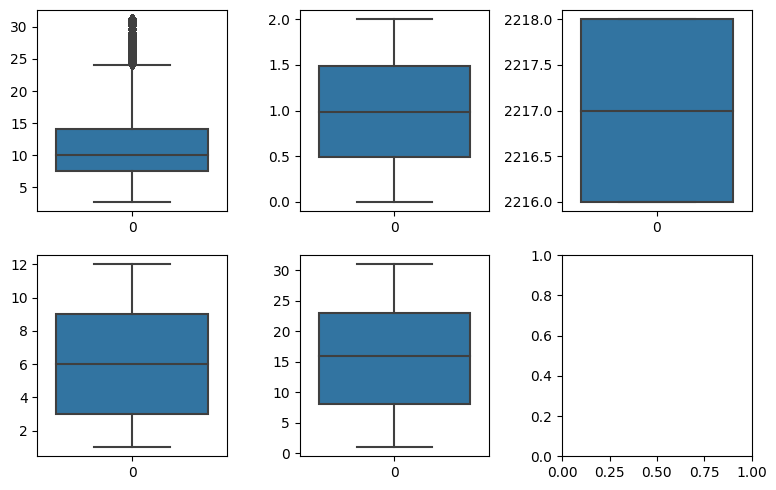

In [89]:
fig, ax = plt.subplots(2, 3, figsize=(8, 5))
plt1 = sns.boxplot(transaction_df['price'], ax=ax[0, 0])
plt2 = sns.boxplot(transaction_df['amount'], ax=ax[0, 1])
plt3 = sns.boxplot(transaction_df['year'], ax=ax[0, 2])
plt1 = sns.boxplot(transaction_df['month'], ax=ax[1, 0])
plt2 = sns.boxplot(transaction_df['day'], ax=ax[1, 1])
# plt3 = sns.boxplot(transaction_df['day'], ax=ax[1, 2])

plt.tight_layout()

**Выбросы в переменных (данные о транзакциях):**
* `price`: на графике выбросами определены цены примерно от $25$, здесь необходимо проверить существования факторов повышения цены, если такие факторы есть, то данные значения не являются для нас выбросами, они являются значимыми данными;
* `amount`: здесь выбросы не наблюдаются;
* `year`,`month`,`day`: здесь все также хорошо, выбросы не наблюдаются.

In [90]:
# для удобства анализа цены добавим новые поля
new_competitors_df['year'] = new_competitors_df['date'].dt.year
new_competitors_df['month'] = new_competitors_df['date'].dt.month
new_competitors_df['day'] = new_competitors_df['date'].dt.day

new_competitors_df.head(2)

,place,product,competitor,price,date,year,month,day
0,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-04,2216,1,4
1,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-05,2216,1,5


In [91]:
# переменные, которые мы проверим на выбросы
competitors_vars = new_competitors_df.describe().columns
competitors_vars

Index(['price', 'year', 'month', 'day'], dtype='object')

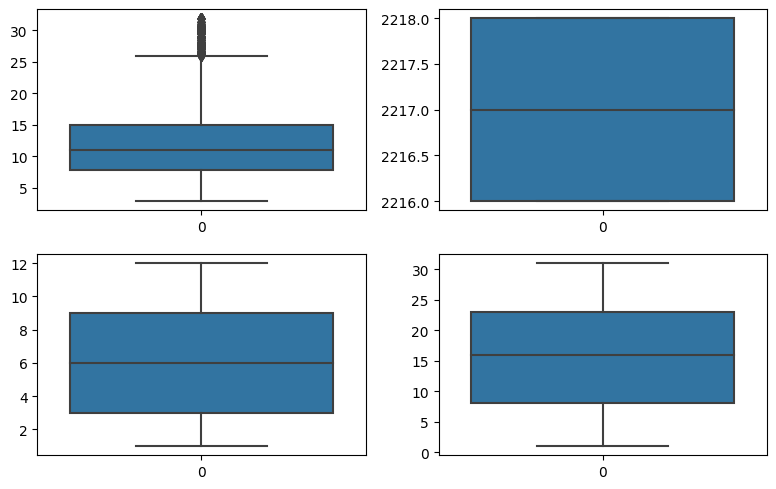

In [92]:
fig, ax = plt.subplots(2, 2, figsize=(8, 5))
plt1 = sns.boxplot(new_competitors_df['price'], ax=ax[0, 0])
plt2 = sns.boxplot(new_competitors_df['year'], ax=ax[0, 1])
plt1 = sns.boxplot(new_competitors_df['month'], ax=ax[1, 0])
plt2 = sns.boxplot(new_competitors_df['day'], ax=ax[1, 1])

plt.tight_layout()

**Выбросы в переменных (данные о ценах конкурентов):**
* `price`: на графике выбросами определены цены примерно от $25$, как это наблюдалось и в данных о транзакциях;
* `year`,`month`,`day`: здесь все также хорошо, выбросы не наблюдаются.

In [93]:
# для удобства анализа цены добавим новые поля
weather_df['year'] = weather_df['date'].dt.year
weather_df['month'] = weather_df['date'].dt.month
weather_df['day'] = weather_df['date'].dt.day

weather_df.head(2)

,place,hot,rain,snow,date,year,month,day
0,Фалькония,0,0,0,2216-01-02,2216,1,2
1,Анор Лондо,1,0,0,2216-01-02,2216,1,2


In [94]:
# переменные, которые мы проверим на выбросы
weather_vars = weather_df.describe().columns
weather_vars

Index(['hot', 'rain', 'snow', 'year', 'month', 'day'], dtype='object')

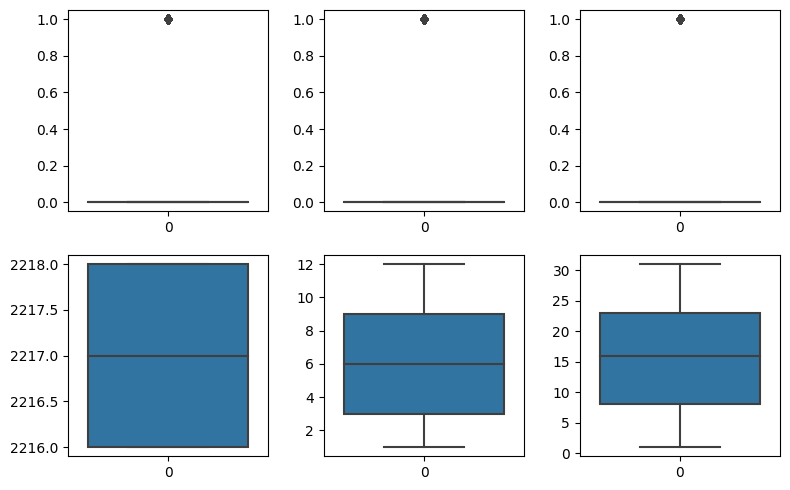

In [95]:
fig, ax = plt.subplots(2, 3, figsize=(8, 5))
plt1 = sns.boxplot(weather_df['hot'], ax=ax[0, 0])
plt2 = sns.boxplot(weather_df['rain'], ax=ax[0, 1])
plt3 = sns.boxplot(weather_df['snow'], ax=ax[0, 2])
plt1 = sns.boxplot(weather_df['year'], ax=ax[1, 0])
plt2 = sns.boxplot(weather_df['month'], ax=ax[1, 1])
plt3 = sns.boxplot(weather_df['day'], ax=ax[1, 2])

plt.tight_layout()

**Выбросы в переменных (данные о погоде):**
* `hot`,`rain`,`snow`: здесь все хорошо, так как бинарные переменные принимают ожидаемые значения ($0$ и $1$), мы дополнительно в этом удостоверились;
* `year`,`month`,`day`: здесь все также хорошо, выбросы не наблюдаются.

In [96]:
# для удобства анализа цены добавим новые поля
cost_df['year'] = cost_df['date'].dt.year
cost_df['month'] = cost_df['date'].dt.month
cost_df['day'] = cost_df['date'].dt.day

cost_df.head(2)

,place,product,cost,date,year,month,day
0,Анор Лондо,Целебные травы,2.07,2216-01-02,2216,1,2
1,Анор Лондо,Целебные травы,3.07,2216-01-26,2216,1,26


In [97]:
# переменные, которые мы проверим на выбросы
cost_vars = cost_df.describe().columns
cost_vars

Index(['cost', 'year', 'month', 'day'], dtype='object')

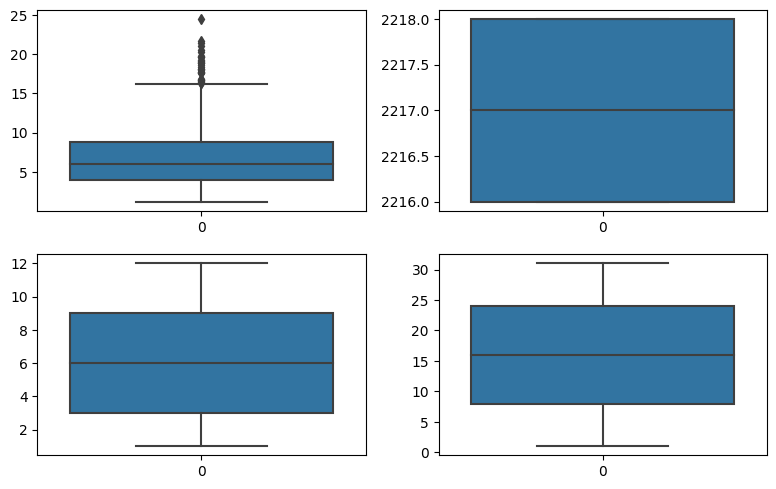

In [98]:
fig, ax = plt.subplots(2, 2, figsize=(8, 5))
plt1 = sns.boxplot(cost_df['cost'], ax=ax[0, 0])
plt2 = sns.boxplot(cost_df['year'], ax=ax[0, 1])
plt1 = sns.boxplot(cost_df['month'], ax=ax[1, 0])
plt2 = sns.boxplot(cost_df['day'], ax=ax[1, 1])

plt.tight_layout()

**Выбросы в переменных (данные о себестоимости):**
* `cost`: здесь наблюдаются выбросы примерно от $15$, что наводит на мысль о том, что выбросы в распределениях цен и у предыдущего управляющего, и у конкурентов оправданы;
* `year`,`month`,`day`: здесь все также хорошо, выбросы не наблюдаются.


**Общий вывод по обработке выбросов:**
* на данном этапе удалять выбросы не будем в целях сохранения значимых данных;
* если построенные модели будут иметь некорректируемые ошибки, то можно будет вернутья на данный этап.

### Обработка категориальных переменных и создание новых переменных

Посмотрим на категориальные переменные:

In [99]:
print(transaction_df.describe(include='object'))
transaction_cat_vars = transaction_df.describe(include='object').columns

       product      place
count   866588     866588
unique       3          5
top      Эстус  Фалькония
freq    301043     190767


In [100]:
print(new_competitors_df.describe(include='object'))
competitors_cat_vars = new_competitors_df.describe(include='object').columns

             place product competitor
count        37958   37958      37958
unique           5       3          4
top     Анор Лондо   Эстус      ЛилIT
freq          7673   12680       9581


In [101]:
print(weather_df.describe(include='object'))
weather_cat_vars = weather_df.describe(include='object').columns

            place
count        5000
unique          5
top     Фалькония
freq         1000


In [102]:
print(cost_df.describe(include='object'))
cost_cat_vars = cost_df.describe(include='object').columns

             place            product
count         1117               1117
unique           5                  3
top     Анор Лондо  Эльфийская пыльца
freq           226                464


Как видно из таблиц, все категориальные переменные имеют значения, которые равнозначны по своему смыслу, то есть некорректно утверждать, что, например, Эльфийская пыльца важнее или значимее, чем Эстус.

Это говорит о том, что для обработки категориальных переменных в таблицах можно применить One Hot Encoding.

In [103]:
transaction_df = pd.get_dummies(transaction_df, columns=transaction_cat_vars)
transaction_df.head(1)

,price,amount,datetime,year,month,day,product_Целебные травы,product_Эльфийская пыльца,product_Эстус,place_Анор Лондо,place_Врата Балдура,place_Кеджистан,place_Нокрон,place_Фалькония
0,3.9,1.242125,2216-01-02 16:28:00,2216,1,2,1,0,0,1,0,0,0,0


In [104]:
# переименуем столбцы в нужном нам стиле
transaction_df = transaction_df.rename(columns={
    'product_Целебные травы': 'product_healing_herbs',
    'product_Эльфийская пыльца': 'product_elf_pollen',
    'product_Эстус': 'product_estus',
    'place_Анор Лондо': 'place_anor_londo',
    'place_Врата Балдура': 'place_baldur_gate',
    'place_Кеджистан': 'place_kejistan',
    'place_Нокрон': 'place_nocron',
    'place_Фалькония': 'place_falconia'}
    )

transaction_df.head(1)

,price,amount,datetime,year,month,day,product_healing_herbs,product_elf_pollen,product_estus,place_anor_londo,place_baldur_gate,place_kejistan,place_nocron,place_falconia
0,3.9,1.242125,2216-01-02 16:28:00,2216,1,2,1,0,0,1,0,0,0,0


In [105]:
new_competitors_df = pd.get_dummies(new_competitors_df, columns=competitors_cat_vars)
new_competitors_df.head(1)

,price,date,year,month,day,place_Анор Лондо,place_Врата Балдура,place_Кеджистан,place_Нокрон,place_Фалькония,product_Целебные травы,product_Эльфийская пыльца,product_Эстус,competitor_Арториас&Co,competitor_Длань господня,competitor_ЛилIT,competitor_Светлые Души
0,3.78,2216-01-04,2216,1,4,1,0,0,0,0,1,0,0,1,0,0,0


In [106]:
# переименуем столбцы в нужном нам стиле
new_competitors_df = new_competitors_df.rename(columns={
    'product_Целебные травы': 'product_healing_herbs',
    'product_Эльфийская пыльца': 'product_elf_pollen',
    'product_Эстус': 'product_estus',
    'place_Анор Лондо': 'place_anor_londo',
    'place_Врата Балдура': 'place_baldur_gate',
    'place_Кеджистан': 'place_kejistan',
    'place_Нокрон': 'place_nocron',
    'place_Фалькония': 'place_falconia',
    'competitor_Арториас&Co': 'place_artorias_co',
    'competitor_Длань господня': 'place_hand_of_god',
    'competitor_ЛилIT': 'place_lilit',
    'competitor_Светлые Души': 'place_light_souls'}
    )

new_competitors_df.head(1)

,price,date,year,month,day,place_anor_londo,place_baldur_gate,place_kejistan,place_nocron,place_falconia,product_healing_herbs,product_elf_pollen,product_estus,place_artorias_co,place_hand_of_god,place_lilit,place_light_souls
0,3.78,2216-01-04,2216,1,4,1,0,0,0,0,1,0,0,1,0,0,0


In [107]:
weather_df = pd.get_dummies(weather_df, columns=weather_cat_vars)
weather_df.head(1)

,hot,rain,snow,date,year,month,day,place_Анор Лондо,place_Врата Балдура,place_Кеджистан,place_Нокрон,place_Фалькония
0,0,0,0,2216-01-02,2216,1,2,0,0,0,0,1


In [108]:
# переименуем столбцы в нужном нам стиле
weather_df = weather_df.rename(columns={
    'place_Анор Лондо': 'place_anor_londo',
    'place_Врата Балдура': 'place_baldur_gate',
    'place_Кеджистан': 'place_kejistan',
    'place_Нокрон': 'place_nocron',
    'place_Фалькония': 'place_falconia'}
    )

weather_df.head(1)

,hot,rain,snow,date,year,month,day,place_anor_londo,place_baldur_gate,place_kejistan,place_nocron,place_falconia
0,0,0,0,2216-01-02,2216,1,2,0,0,0,0,1


In [109]:
cost_df = pd.get_dummies(cost_df, columns=cost_cat_vars)
cost_df.head(1)

,cost,date,year,month,day,place_Анор Лондо,place_Врата Балдура,place_Кеджистан,place_Нокрон,place_Фалькония,product_Целебные травы,product_Эльфийская пыльца,product_Эстус
0,2.07,2216-01-02,2216,1,2,1,0,0,0,0,1,0,0


In [110]:
# переименуем столбцы в нужном нам стиле
cost_df = cost_df.rename(columns={
    'product_Целебные травы': 'product_healing_herbs',
    'product_Эльфийская пыльца': 'product_elf_pollen',
    'product_Эстус': 'product_estus',
    'place_Анор Лондо': 'place_anor_londo',
    'place_Врата Балдура': 'place_baldur_gate',
    'place_Кеджистан': 'place_kejistan',
    'place_Нокрон': 'place_nocron',
    'place_Фалькония': 'place_falconia'}
    )

cost_df.head(1)

,cost,date,year,month,day,place_anor_londo,place_baldur_gate,place_kejistan,place_nocron,place_falconia,product_healing_herbs,product_elf_pollen,product_estus
0,2.07,2216-01-02,2216,1,2,1,0,0,0,0,1,0,0


> Если бы у меня было больше времени, я бы изменила переменные в таблице данных о погоде.

Например, аномальная жара противоречит снегу в одном и том же месте в одно и то же время. Снег с дождем может наблюдаться также, как и жара с дождем, но жара и снег однозначно противоречат друг другу, поэтому:
* необходимо проверить, есть ли такие наблюдения, когда погода характеризовалась и жарой, и снегом;
* жару и снег можно объединить в одну переменную, но так, чтобы эта переменная была сопоставима с бинарной переменной `rain`.

**Вывод по обработке категориальных переменных:**
* все категориальные переменные были обработаны с помощью One Hot Encoding;
* были детализированы значения дат;
* на данном этапе не было принято решения удаления переменных, так как веских причин для этого не было выявлено.

### Одномерный анализ

Начнем с транзакций. Необходимо посмотреть динамику цены и объема продаж по каждому продукту:

In [111]:
def draw_price_amount_dependence(df, product_column_name: str, y: str, year: int=None) -> None:
    """
    Визуализирует y продукта product_column_name в зависимости от времени,
    если year=None, в противном случае — в зависимости от времени в году year.
    """
    if year is None:
        if y in ('price', 'cost'):
            price_df = df[df[product_column_name] == 1].groupby('date', as_index=False).agg({y: 'mean'})
        else:
            price_df = df[df[product_column_name] == 1].groupby('date', as_index=False).agg({y: 'sum'})
    else:
        if y in ('price', 'cost'):
            price_df = df[(df[product_column_name] == 1) & (df['date'].apply(lambda x: x.year) == year)] \
            .groupby('date', as_index=False) \
            .agg({y: 'mean'})
        else:
             price_df = df[(df[product_column_name] == 1) & (df['date'].apply(lambda x: x.year) == year)] \
            .groupby('date', as_index=False) \
            .agg({y: 'sum'})

    sns.set_style('whitegrid')
    sns.lineplot(data=price_df, x='date', y=y)
    plt.xlabel('Date')
    plt.ylabel(f'{y.title()} of {" ".join(product_column_name.split("_")[1:]).capitalize()}')
    plt.show()

In [112]:
# сформируем новую колонку
transaction_df['date'] = transaction_df.datetime.dt.date

transaction_df.head(2)

,price,amount,datetime,year,month,day,product_healing_herbs,product_elf_pollen,product_estus,place_anor_londo,place_baldur_gate,place_kejistan,place_nocron,place_falconia,date
0,3.9,1.242125,2216-01-02 16:28:00,2216,1,2,1,0,0,1,0,0,0,0,2216-01-02
1,3.9,0.584359,2216-01-02 16:21:00,2216,1,2,1,0,0,1,0,0,0,0,2216-01-02


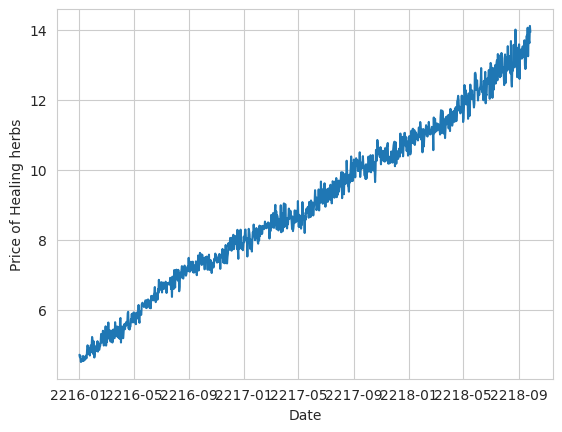

In [113]:
# по всем годам
draw_price_amount_dependence(transaction_df, 'product_healing_herbs', 'price')

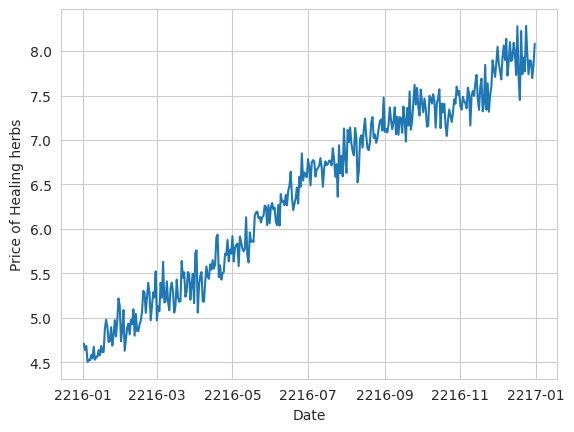

In [114]:
draw_price_amount_dependence(transaction_df, 'product_healing_herbs', 'price', 2216)

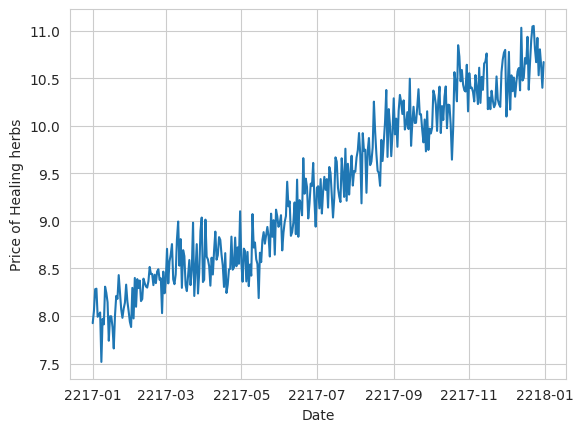

In [115]:
draw_price_amount_dependence(transaction_df, 'product_healing_herbs', 'price', 2217)

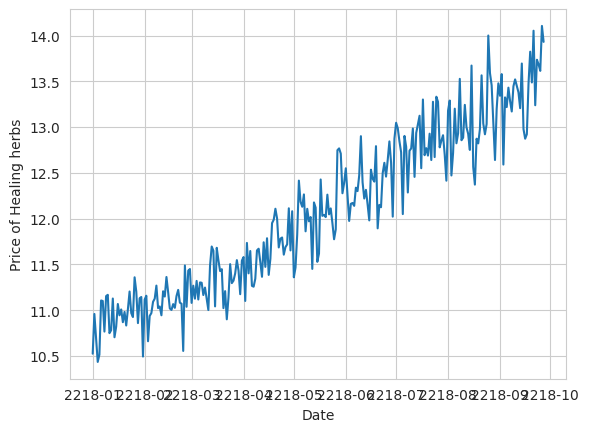

In [116]:
draw_price_amount_dependence(transaction_df, 'product_healing_herbs', 'price', 2218)

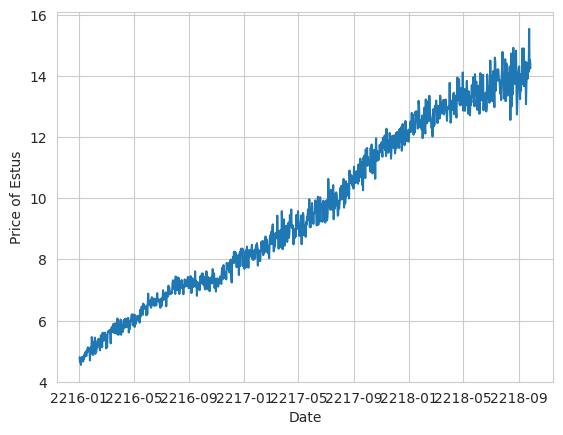

In [117]:
# по всем годам
draw_price_amount_dependence(transaction_df, 'product_estus', 'price')

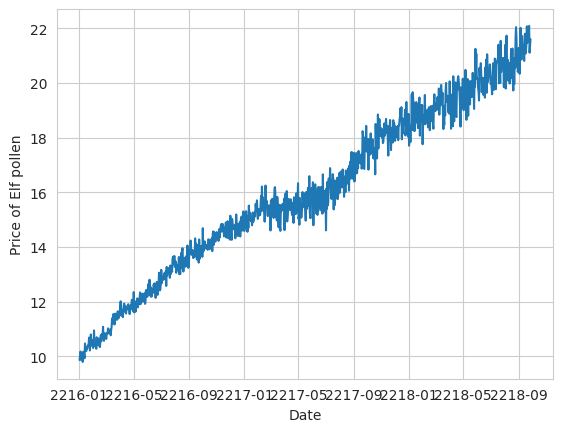

In [118]:
# по всем годам
draw_price_amount_dependence(transaction_df, 'product_elf_pollen', 'price')

Не рассмотрены по годам два оставшихся продукта, так как по общему графику видно, что к $2218$ году размах цен увеличивается по каждому из продуктов ("скачки" становятся сильнее).

Рассмотрим объем продаж по каждому из продуктов в той же динамике:

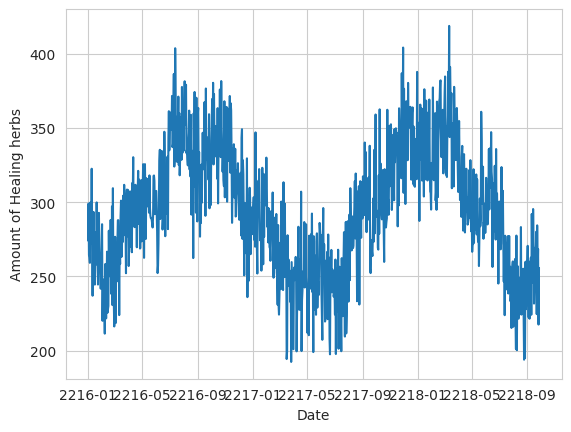

In [119]:
# по всем годам
draw_price_amount_dependence(transaction_df, 'product_healing_herbs', 'amount')

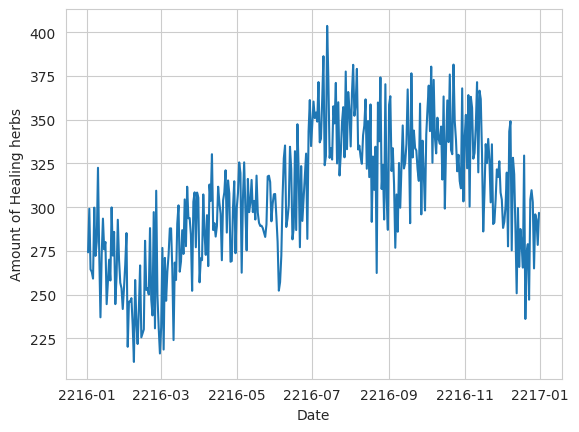

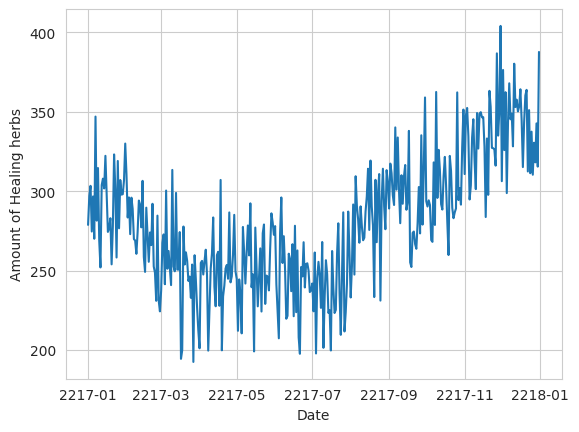

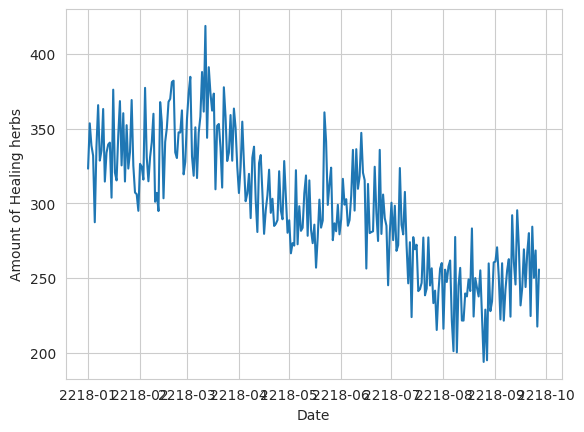

In [120]:
# детализируем
draw_price_amount_dependence(transaction_df, 'product_healing_herbs', 'amount', 2216)
draw_price_amount_dependence(transaction_df, 'product_healing_herbs', 'amount', 2217)
draw_price_amount_dependence(transaction_df, 'product_healing_herbs', 'amount', 2218)

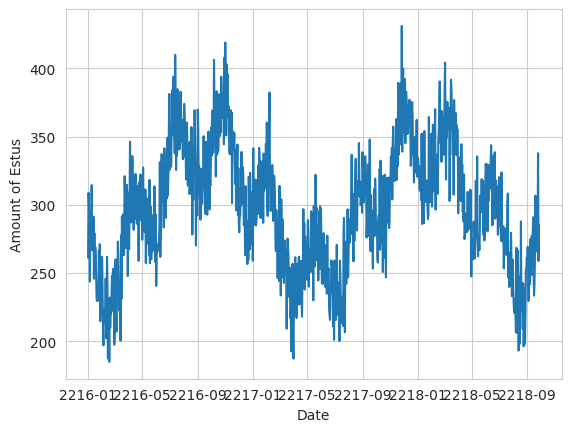

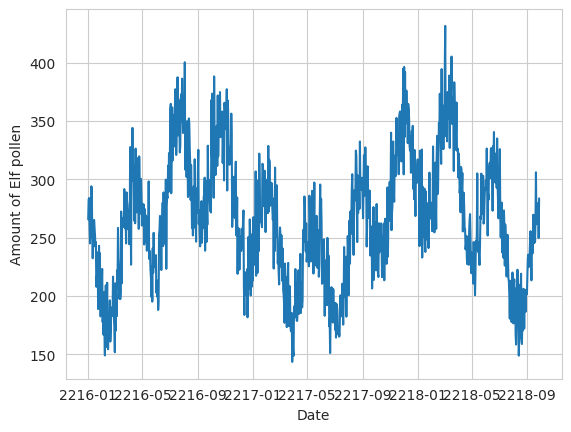

In [121]:
# по всем годам
draw_price_amount_dependence(transaction_df, 'product_estus', 'amount')
draw_price_amount_dependence(transaction_df, 'product_elf_pollen', 'amount')

Так как прогноз ожидается по дням, то имеет смысл рассматривать данные по месяцам. Графики цены были очевидны, наблюдался только рост по всем продуктам. Графики количества продаж немного отличаются друг от друга, в каждом из продукто, грубо говоря, наблюдается сначала рост с изменением направления тренда ($2016$ год), потом небольшое падение с ростом ($2017$ год), потом снова падение ($2018$ год).  

Посмотрим на цены конкурентов:

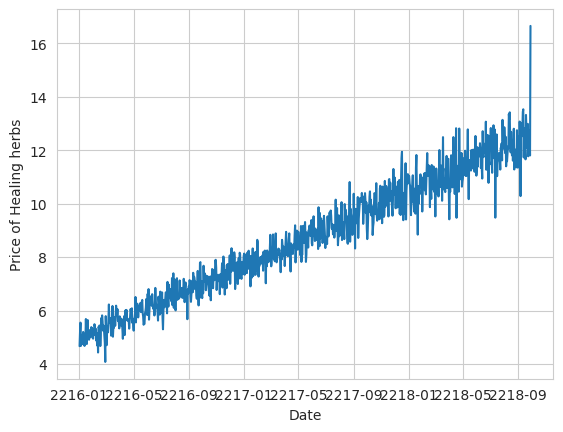

In [122]:
# по всем годам
draw_price_amount_dependence(new_competitors_df, 'product_healing_herbs', 'price')

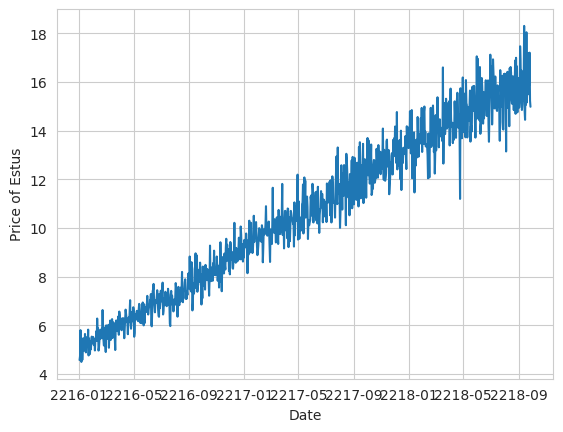

In [123]:
# по всем годам
draw_price_amount_dependence(new_competitors_df, 'product_estus', 'price')

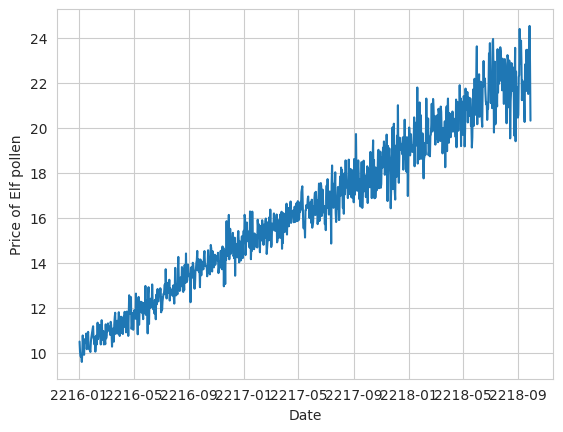

In [124]:
# по всем годам
draw_price_amount_dependence(new_competitors_df, 'product_elf_pollen', 'price')

При сопоставлении цен нашей компани и цен конкурентов можно заметить один и тот же тренд, но он формируется по-разному:
1. В нашем случае разброс цен меньше и имеет "перегибы" (видно на примере эльфийской пыльцы).
2. В случае конкурентов: разброс цен постепенно (почти равномерно) расширяется.

Аналогично рассмотрим себестоимость:

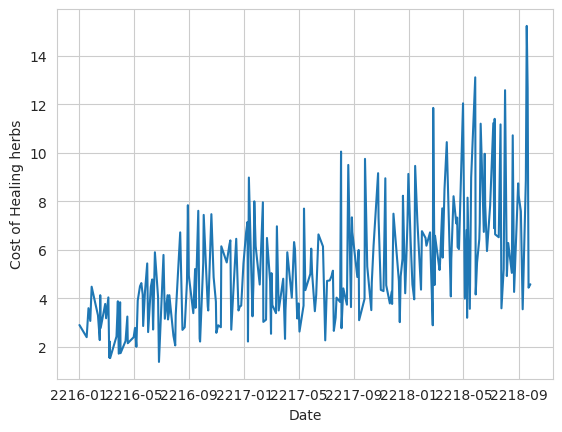

In [125]:
# по всем годам
draw_price_amount_dependence(cost_df, 'product_healing_herbs', 'cost')

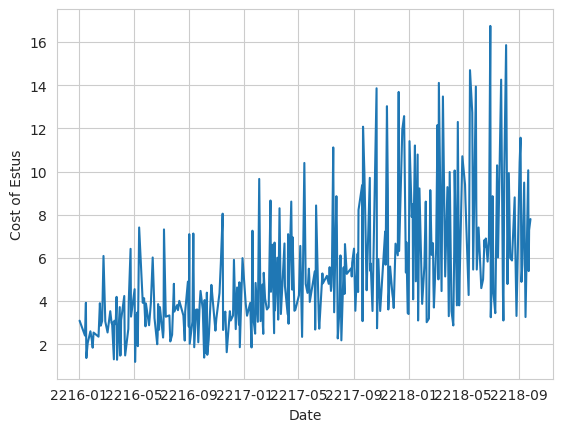

In [126]:
# по всем годам
draw_price_amount_dependence(cost_df, 'product_estus', 'cost')

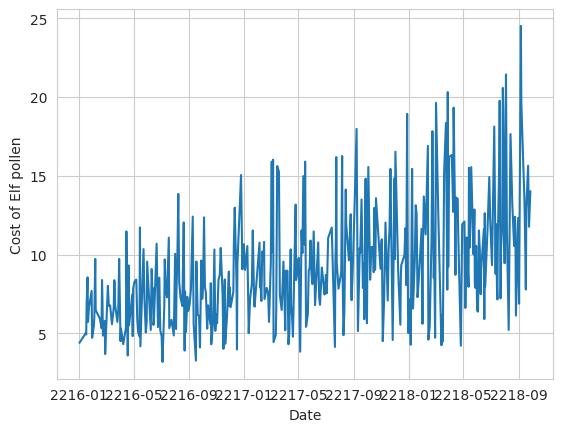

In [127]:
# по всем годам
draw_price_amount_dependence(cost_df, 'product_elf_pollen', 'cost')

Здесь себестоимость тоже растет, нужно учитывать тот факт, что наблюдений по себестоимости не так много, как по ценам.

**Вывод по одномерному анализу:**
* и в случае нашей компании, и в случае конкурентов, цены растут в представленные $3$ года;
* раброс цены нашей компании меньше, чем у конкурентов, и имеет свои "перегибы";
* себестоимость также росла в представленные $3$ года, что соответствует логике установления цены.

Интересно посмотреть динамику прибыли нашей компани и конкурентов.

## **2.2. Анализ таблиц путем их объединения**

### Подготовка одной таблицы

In [ ]:
transaction_df['date'] = pd.to_datetime(transaction_df['date'])
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 866588 entries, 0 to 866587
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   price                  866588 non-null  float64       
 1   amount                 866588 non-null  float64       
 2   datetime               866588 non-null  datetime64[ns]
 3   year                   866588 non-null  int64         
 4   month                  866588 non-null  int64         
 5   day                    866588 non-null  int64         
 6   product_healing_herbs  866588 non-null  uint8         
 7   product_elf_pollen     866588 non-null  uint8         
 8   product_estus          866588 non-null  uint8         
 9   place_anor_londo       866588 non-null  uint8         
 10  place_baldur_gate      866588 non-null  uint8         
 11  place_kejistan         866588 non-null  uint8         
 12  place_nocron           866588 non-null  uint

In [ ]:
# формируем словарь данных по себестоимости
cost_data = {}

for i in range(len(cost_df)):
    # парсим дату
    year, month, day = cost_df.loc[i]['year'], cost_df.loc[i]['month'], cost_df.loc[i]['day']
    cost = cost_df.loc[i]['cost']

    # парсим место
    for place in cost_df.loc[i].index:
        if 'place' in place:
            if cost_df.loc[i][place]:
                key_place = place
                break

    # парсим продукт
    for product in cost_df.loc[i].index:
        if 'product' in product:
            if cost_df.loc[i][product]:
                key_product = product
                break

    # создаем ключ-значение
    if (year, month, place, product) not in cost_data:
        cost_data[(year, month, key_place, key_product)] = {'days': [], 'costs': []}
    else:
        cost_data[(year, month, key_place, key_product)]['days'].append(day)
        cost_data[(year, month, key_place, key_product)]['costs'].append(cost)

# print(cost_data)

ВНИМАНИЕ: следующая ячейка отработала за $21$ минуту!

In [ ]:
costs = []

for i in range(len(transaction_df)):
    year, month, day = transaction_df.loc[i]['year'], transaction_df.loc[i]['month'], transaction_df.loc[i]['day']

    # парсим место
    for place in transaction_df.loc[i].index:
        if 'place' in place:
            if transaction_df.loc[i][place]:
                key_place = place
                break

    # парсим продукт
    for product in transaction_df.loc[i].index:
        if 'product' in product:
            if transaction_df.loc[i][product]:
                key_product = product
                break

    # достаем словарь значений себестоимости по дням
    if (year, month, key_place, key_product) in cost_data:
        data = cost_data[(year, month, key_place, key_product)]
    else:
        costs.append(None)
        continue

    # достаем цену и добавляем верное значение себестоимости
    if data['days']:
        if len(data['days']) == 1:
            costs.append(data['costs'][0])
            continue
        else:
            for i in range(len(data['days'])):
                if day >= data['days'][i]:
                    costs.append(data['costs'][i])
                    break
            else:
                costs.append(None)
    else:
        costs.append(None)

transaction_df['cost'] = costs
transaction_df.head()

,price,amount,datetime,year,month,day,product_healing_herbs,product_elf_pollen,product_estus,place_anor_londo,place_baldur_gate,place_kejistan,place_nocron,place_falconia,date,cost
0,3.9,1.242125,2216-01-02 16:28:00,2216,1,2,1,0,0,1,0,0,0,0,2216-01-02,3.07
1,3.9,0.091347,2216-01-02 16:21:00,2216,1,2,1,0,0,1,0,0,0,0,2216-01-02,3.07
2,3.9,0.882450,2216-01-02 03:03:00,2216,1,2,1,0,0,1,0,0,0,0,2216-01-02,3.07
3,3.9,0.621377,2216-01-02 03:12:00,2216,1,2,1,0,0,1,0,0,0,0,2216-01-02,3.07
4,3.9,1.367161,2216-01-02 05:33:00,2216,1,2,1,0,0,1,0,0,0,0,2216-01-02,3.07


In [ ]:
transaction_df = transaction_df.fillna({'cost': 'mean'})
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 866588 entries, 0 to 866587
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   price                  866588 non-null  float64       
 1   amount                 866588 non-null  float64       
 2   datetime               866588 non-null  datetime64[ns]
 3   year                   866588 non-null  int64         
 4   month                  866588 non-null  int64         
 5   day                    866588 non-null  int64         
 6   product_healing_herbs  866588 non-null  uint8         
 7   product_elf_pollen     866588 non-null  uint8         
 8   product_estus          866588 non-null  uint8         
 9   place_anor_londo       866588 non-null  uint8         
 10  place_baldur_gate      866588 non-null  uint8         
 11  place_kejistan         866588 non-null  uint8         
 12  place_nocron           866588 non-null  uint

In [ ]:
cols = transaction_df.select_dtypes(include=['object']).columns
transaction_df[cols] = transaction_df[cols].apply(pd.to_numeric, downcast='float', errors='coerce')
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 866588 entries, 0 to 866587
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   price                  866588 non-null  float64       
 1   amount                 866588 non-null  float64       
 2   datetime               866588 non-null  datetime64[ns]
 3   year                   866588 non-null  int64         
 4   month                  866588 non-null  int64         
 5   day                    866588 non-null  int64         
 6   product_healing_herbs  866588 non-null  uint8         
 7   product_elf_pollen     866588 non-null  uint8         
 8   product_estus          866588 non-null  uint8         
 9   place_anor_londo       866588 non-null  uint8         
 10  place_baldur_gate      866588 non-null  uint8         
 11  place_kejistan         866588 non-null  uint8         
 12  place_nocron           866588 non-null  uint

In [ ]:
# целевая переменная
transaction_df = transaction_df.assign(revenue = transaction_df['amount']*(transaction_df['price'] - transaction_df['cost']))
transaction_df[['datetime', 'amount', 'price', 'cost', 'revenue']].head()

,datetime,amount,price,cost,revenue
0,2216-01-02 16:28:00,1.242125,3.9,3.07,1.030964
1,2216-01-02 16:21:00,0.091347,3.9,3.07,0.075818
2,2216-01-02 03:03:00,0.882450,3.9,3.07,0.732434
3,2216-01-02 03:12:00,0.621377,3.9,3.07,0.515743
4,2216-01-02 05:33:00,1.367161,3.9,3.07,1.134744


### Многомерный анализ

<ipython-input-310-fa739401b3b0>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(transaction_df.corr(), fignum=f.number)


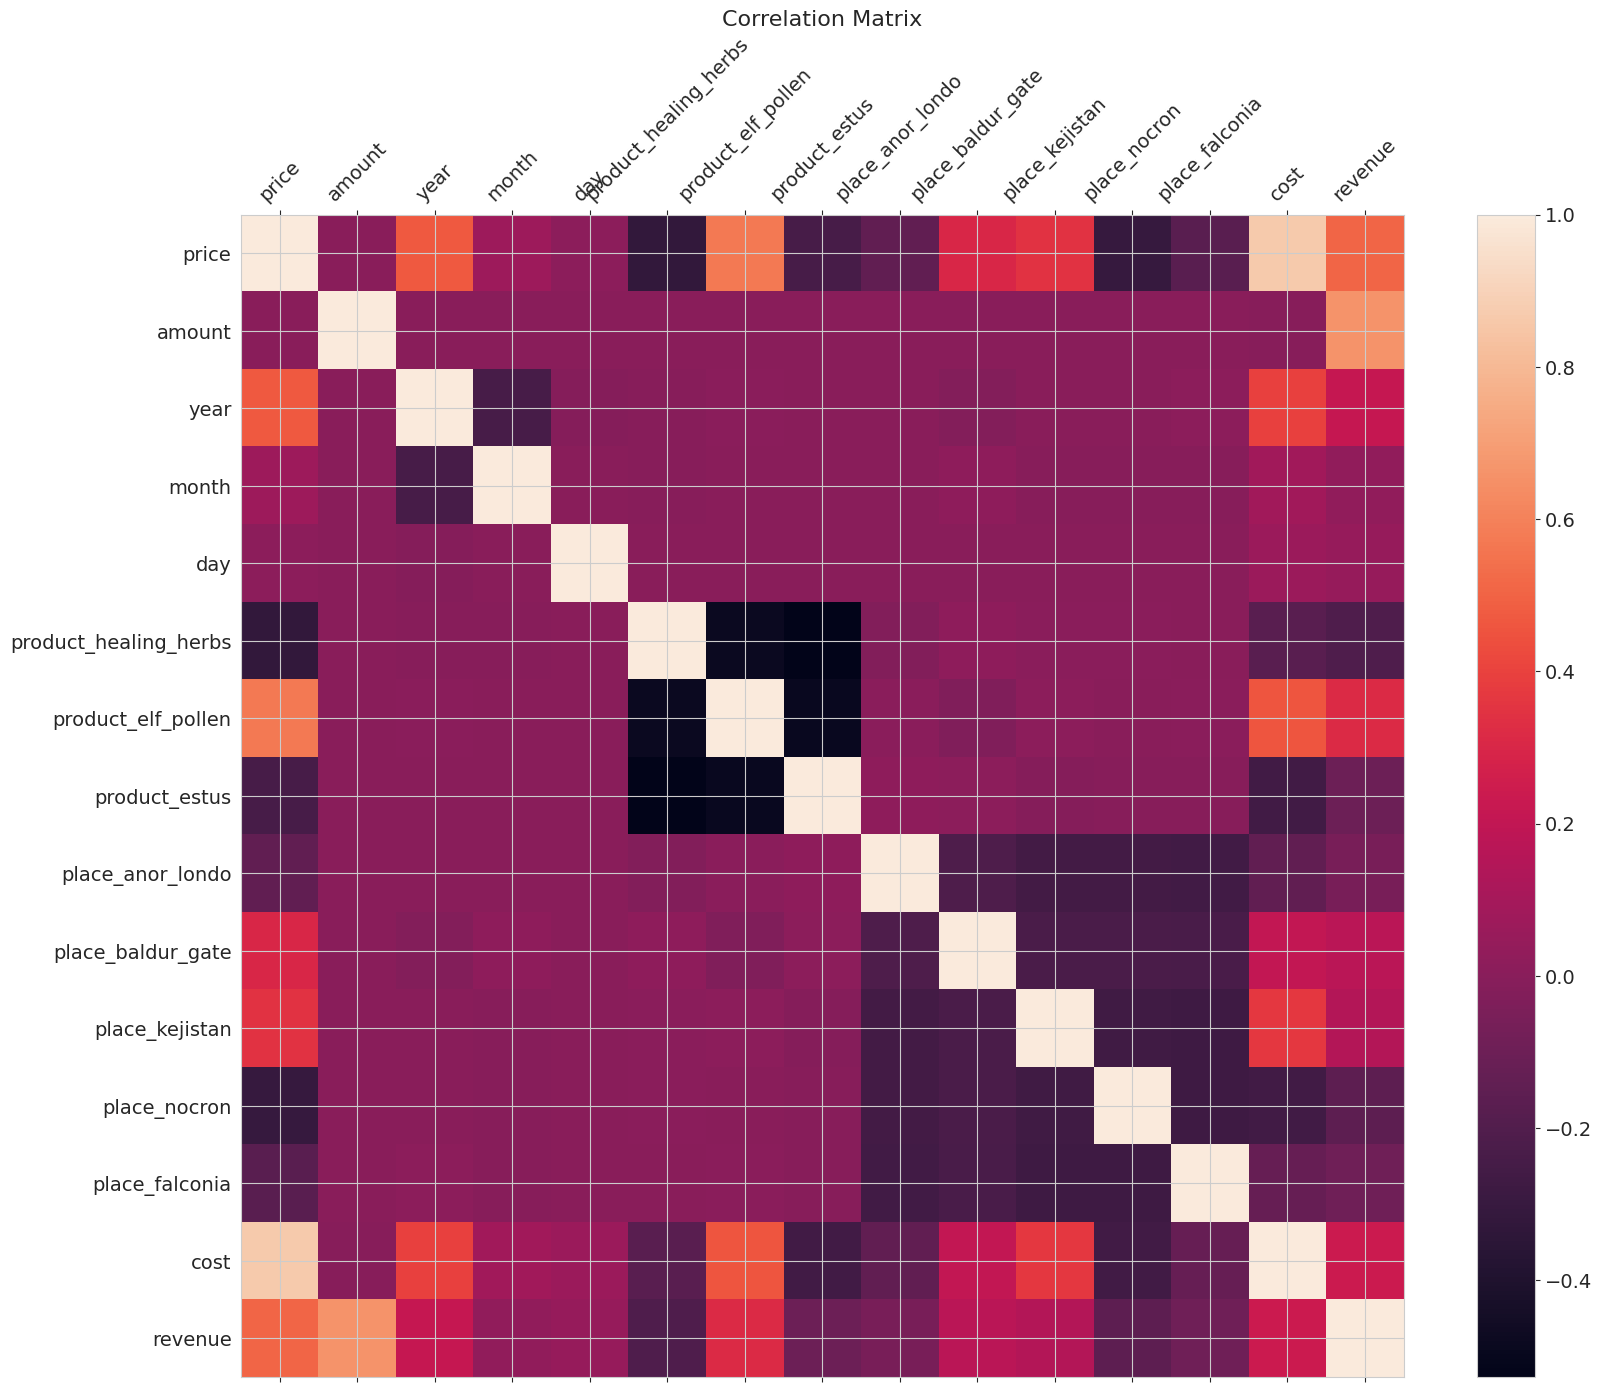

In [ ]:
f = plt.figure(figsize=(19, 15))
plt.matshow(transaction_df.corr(), fignum=f.number)
plt.xticks(range(transaction_df.select_dtypes(['number']).shape[1]), transaction_df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(transaction_df.select_dtypes(['number']).shape[1]), transaction_df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

**Вывод по многомерному анализу:**
* корреляционная матрица показала, что цена и количество продаваемого продукта имеют сильную связь с прибылью, что подтверждает физический смысл переменных;
* цена имеет сильную связь с себестоимостью.

Конечно, данный подраздел не претендует быть досконально проработанным, поэтому выводы пока короткие.

# **3. Построение моделей**
---
* подготовку данных для построения линейной регрессии;
* модель линейной регрессии №1;
* модель линейной регрессии №2 (попытка улучшить метрики качества прогноза);
* модель гребневой регрессии с подбором оптимального значения гиперпараметра $alpha$;
* модель лассо регрессии с подбором оптимального значения гиперпараметра  $alpha$.

> В силу ограниченности времени данный раздел скорее предназначен для того, чтобы получить минимальный результат.

**Цель:** составить прогноз цены.

In [129]:
my_random_state = 42

## **3.1. Модель линейной регрессии №1**

In [130]:
# берем все переменные
Xs = transaction_df.drop(['price', 'datetime', 'date', 'year', 'month', 'day'], axis=1)
y = transaction_df['price']
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, y, test_size=0.30,
                                                    random_state=my_random_state)

In [131]:
Xs_train.head()

,amount,product_healing_herbs,product_elf_pollen,product_estus,place_anor_londo,place_baldur_gate,place_kejistan,place_nocron,place_falconia
768357,0.069523,0,1,0,0,0,0,0,1
90940,0.345820,1,0,0,1,0,0,0,0
621529,1.208989,0,0,1,0,0,0,1,0
262872,1.975358,0,0,1,0,1,0,0,0
442966,1.812146,0,1,0,0,0,1,0,0


In [132]:
# здесь была обнаружена ошибка, которая преследовала всю работу...
Xs_train.isna().sum()

amount                   0
product_healing_herbs    0
product_elf_pollen       0
product_estus            0
place_anor_londo         0
place_baldur_gate        0
place_kejistan           0
place_nocron             0
place_falconia           0
dtype: int64

In [134]:
# создание и обучение модели
reg_1 = LinearRegression(fit_intercept=True)
reg_1.fit(Xs_train, y_train)

LinearRegression()

In [135]:
print(reg_1.coef_, reg_1.intercept_)

[-6.29348394e-04  6.91593988e+12  6.91593988e+12  6.91593988e+12
  2.38589910e+13  2.38589910e+13  2.38589910e+13  2.38589910e+13
  2.38589910e+13] -30774930875626.074


In [136]:
print(f'intercept {str(round(reg_1.intercept_, 5)).rjust(42)}')
for coef, col in zip(reg_1.coef_, Xs_train.columns):
    print(f'{str(col).ljust(30)}: {str(round(coef, 5)).rjust(20)}')

intercept                        -30774930875626.074
amount                        :             -0.00063
product_healing_herbs         :    6915939876039.956
product_elf_pollen            :    6915939876047.142
product_estus                 :    6915939876040.652
place_anor_londo              :   23858990999593.453
place_baldur_gate             :   23858990999598.914
place_kejistan                :   23858990999598.633
place_nocron                  :   23858990999591.906
place_falconia                :    23858990999593.29


In [137]:
# R^2 на обучающей выборке
round(reg_1.score(Xs_train, y_train), 5)

0.62248

In [138]:
# прогноз
y_pred = reg_1.predict(Xs_test)

# ошибка прогноза
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

# R^2 на тестовой выборке
r2 = r2_score(y_test, y_pred)

print('MSE модели:', round(mse, 5))
print('MAE модели:', round(mae, 5))
print('MAPE модели:', round(mape * 100, 2), '%')
print('R^2 модели:', round(r2, 5))

MSE модели: 10.95359
MAE модели: 2.5647
MAPE модели: 26.62 %
R^2 модели: 0.62457
